# Machine Learning 2: Regression with Gradient Descent

## Submission by: Mark Preston

### Loading Data

This week, I'll be using the same basic data set from last week to develop a linear regression model to predict temperature. However, this time I'll utilized gradient descent as part of the model fitting. 

In [1]:
import pandas as pd

pd.options.mode.chained_assignment = None

water_data = pd.read_csv("bottle.csv", low_memory=False)

### Part A: Data Cleaning

For the assignment, I'll need to use the following variables:

- T_degC
- Salnty
- STheta
- O2ml_L
- Depthm

As such, I'll start by paring down the initial data frame. The printout below shows a new data frame was created specifically for the modelling work.

In [2]:
water_modelling = water_data[["T_degC", "Salnty", "STheta", "O2ml_L", "Depthm"]]

water_modelling.head()

,T_degC,Salnty,STheta,O2ml_L,Depthm
0,10.50,33.440,25.649,NaN,0
1,10.46,33.440,25.656,NaN,8
2,10.46,33.437,25.654,NaN,10
3,10.45,33.420,25.643,NaN,19
4,10.45,33.421,25.643,NaN,20


#### Remove NaN / NA values from dataset

To ensure the set has all missing values dropped, I'm using the `dropna` function on the new data frame. The new dimensions match the assignment specifications.

In [3]:
water_modelling = water_modelling.dropna()

print("The cleaned data now has", 
      water_modelling.shape[0], "rows and", 
      water_modelling.shape[1], "columns. First 10 rows shown below:")

water_modelling.head(10)

The cleaned data now has 661268 rows and 5 columns. First 10 rows shown below:


,T_degC,Salnty,STheta,O2ml_L,Depthm
2160,10.30,33.030,25.364,5.90,0
2161,18.46,32.920,23.568,6.02,6
2162,10.29,32.951,25.304,6.04,10
2163,10.29,32.990,25.335,6.06,15
2164,10.33,33.005,25.339,6.04,20
2165,10.39,33.054,25.368,6.01,30
2166,10.40,33.060,25.371,6.01,31
2167,10.36,33.150,25.448,5.78,47
2168,10.35,33.167,25.463,5.76,50
2169,10.25,33.260,25.553,5.60,64


#### Remove obvious outliers for STheta

As with last week, there are several outliers present in STheta that need to be removed. To do so, I'm using the same boolean logic that identifies values less than 100 to filter the outliers. Evidently, when adding the new variables and subsequently filtering out the missing values, the STheta outliers were dropped. This can be seen as the number of data frame rows did not change from the previous cleaning steps. As such, the dimensions match the given assignment values.

In [4]:
outlier_identify = water_modelling["STheta"] < 100

water_modelling = water_modelling[outlier_identify]

print("Data set has", water_modelling.shape[0], 
      "rows and", water_modelling.shape[1], 
      "columns following outlier removal")

Data set has 661268 rows and 5 columns following outlier removal


Since two new predictors were added for the assignment, I've included a quick exploratory review of the variables. The pairs plot shows that both new predictors do not have normal distributions. O2 appears to be bimodal, though almost uniform, while Depthm shows a high positive skew. Additionally, Depthm shows a negative correlation with temperature but, the association is highly non-linear so standard correlation is somewhat misleading here. There appears to be a positive correlation between temperature and O2 though.

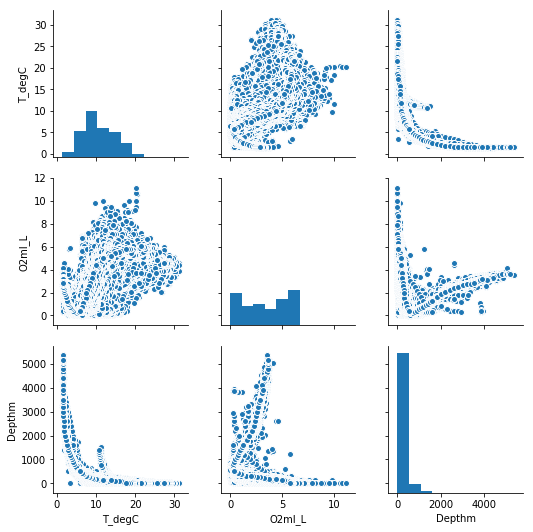

In [25]:
import seaborn as sns

sns.pairplot(water_modelling[["T_degC", "O2ml_L", "Depthm"]])

These correlation observations are confirmed using the matrix below. 

Text(0.5,1,'Correlation matric for water modelling set')

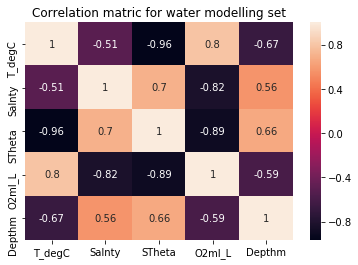

In [14]:
var_corr = water_modelling.corr()

sns.heatmap(var_corr, annot=True, 
            xticklabels=var_corr.columns.values,
            yticklabels=var_corr.columns.values).set_title("Correlation matrix for water modelling set")

### Part B: Train / Test Split & Scaling

Moving into the modelling phase, I'll work towards setting up the data sets for the prediction task.

#### Create X & y objects

Starting here, I've split the predictors and outcome variable into separate objects. Again, the dimensions match the instructions.

In [12]:
from sklearn.model_selection import train_test_split

predictors = water_modelling[["Salnty", "STheta", "O2ml_L", "Depthm"]]

outcome = water_modelling[["T_degC"]]

print("Predictors data shape:", predictors.shape[0], "rows and", predictors.shape[1], "columns")
print("Outcome data shape:", outcome.shape[0], "rows and", outcome.shape[1], "column")

Predictors data shape: 661268 rows and 4 columns
Outcome data shape: 661268 rows and 1 column


#### Generate X_train, X_test, y_train & y_test. Use 80% for train & 20% for test.

Approaching the modelling work, I've conducted the train and test split below. The default proportions using `train_test_split` are usually 75/25, so I've augmented this to ensure an 80/20 split. To confirm this, I've printed out the train and test dimensions.

In [16]:
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, random_state=1017, test_size=.2)

print(
"Training set rows:", X_train.shape[0], "which is", 
    np.round(X_train.shape[0] / water_modelling.shape[0] * 100), 
    "percent of total records"
)

print(
"Test set rows:", X_test.shape[0], "which is", 
    np.round(X_test.shape[0] / water_modelling.shape[0] * 100),
    "percent of total records"
)

Training set rows: 529014 which is 80.0 percent of total records
Test set rows: 132254 which is 20.0 percent of total records


#### Scale all features to improve convergence in Gradient Descent

To ensure that the gradient descent works optimally, I've scaled the train and test set. This standardization is done so all the predictors are on the same scale. Otherwise, the wide variety of value ranges can make the operation bounce from side-to-side. Standardizing each column means subtracting the mean form each value and then dividing them by the standard deviation. I've opted to do this manually to start, which is seen below.

To collect each column's mean and standard deviation, I've used `apply` for both operations and saved the results to a data frame. Following this, each row contains the mean and standard deviation for one column. With this data frame developed, I've created the new standardized training set by turning each column into z-scores. The first five rows of the new set can be seen below.

In [17]:
train_stats =  pd.DataFrame({"var_means": X_train.apply(axis=0, func=np.mean),
                             "var_std": X_train.apply(axis=0, func=np.std)}) 

X_train_scaled = pd.DataFrame((X_train[["Salnty"]] - train_stats["var_means"][0]) / train_stats["var_std"][0])

X_train_scaled["STheta"] = (X_train[["STheta"]] - train_stats["var_means"][1]) / train_stats["var_std"][1]
X_train_scaled["O2ml_L"] = (X_train[["O2ml_L"]] - train_stats["var_means"][2]) / train_stats["var_std"][2]
X_train_scaled["Depthm"] = (X_train[["Depthm"]] - train_stats["var_means"][3]) / train_stats["var_std"][3]

X_train_scaled.head()

,Salnty,STheta,O2ml_L,Depthm
3267,-0.897090,0.006684,0.597124,-0.288835
311485,1.187976,1.263266,-1.558559,1.072631
617217,-0.934013,-1.854919,1.003127,-0.704034
123633,0.514673,0.326523,-0.543551,-0.395049
292627,0.075940,0.360191,-0.345383,-0.304928


Just to verify this work, I've also conducted the same process but, with the `StandardScaler` function. The `head` output shows that it matches the manual approach.

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
sci_kit_scaled = pd.DataFrame(scaler.transform(X_train), columns=[["Salnty", "STheta", "O2ml_L", "Depthm"]])
sci_kit_scaled.head()

,Salnty,STheta,O2ml_L,Depthm
0,-0.897090,0.006684,0.597124,-0.288835
1,1.187976,1.263266,-1.558559,1.072631
2,-0.934013,-1.854919,1.003127,-0.704034
3,0.514673,0.326523,-0.543551,-0.395049
4,0.075940,0.360191,-0.345383,-0.304928


One of the benefits about doing the transformation manually is that the training statistics have been stored to a data frame. This is useful because the test set has to be standardized using the training column means and standard deviations. To do this, I've followed the same standardization procedure here to develop the scaled test set.

In [19]:
X_test_scaled = pd.DataFrame((X_test[["Salnty"]] - train_stats["var_means"][0]) / train_stats["var_std"][0])

X_test_scaled["STheta"] = (X_test[["STheta"]] - train_stats["var_means"][1]) / train_stats["var_std"][1]
X_test_scaled["O2ml_L"] = (X_test[["O2ml_L"]] - train_stats["var_means"][2]) / train_stats["var_std"][2]
X_test_scaled["Depthm"] = (X_test[["Depthm"]] - train_stats["var_means"][3]) / train_stats["var_std"][3]

X_test_scaled.head()

,Salnty,STheta,O2ml_L,Depthm
369164,1.565894,1.578154,-1.423225,2.492032
687155,-0.393199,-0.094318,0.669625,-0.675067
310468,-0.571299,-0.793409,1.143295,-0.642881
210295,0.145443,0.245326,-0.466218,-0.385393
721907,-0.977452,-1.102356,1.157795,-0.675067


### Part C: Linear Regression with sklearn 

#### Create an instance of the LinearRegression class called "lin_reg". Print out the coefficients (including the intercept).

Moving into the modelling phase, I've developed a linear regression model using Sci-Kit Learn here. The intercept and slope coefficients for each predictor are included.

In [20]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

print("Temperature model intercept:", lin_reg.intercept_[0])
print("Temperature model coefficients for Salnty:", lin_reg.coef_[0,0])
print("Temperature model coefficients for STheta:", lin_reg.coef_[0,1])
print("Temperature model coefficients for O2ml_L:", lin_reg.coef_[0,2])
print("Temperature model coefficients for Depthm:", lin_reg.coef_[0,3])

Temperature model intercept: 10.916207986932454
Temperature model coefficients for Salnty: 1.6316697736471633
Temperature model coefficients for STheta: -4.634727452069108
Temperature model coefficients for O2ml_L: 0.3013397048854958
Temperature model coefficients for Depthm: -0.47520777626713706


#### Predict T_degC for the test data using lin_reg

The initial predictions shows a close fit the actual temperature values. As a guess, it looks like these may be an improvement on the previous assignment owing to additional predictors.

In [21]:
y_test["y_pred_sklearn"] = lin_reg.predict(X_test_scaled)

y_test.head(10)

,T_degC,y_pred_sklearn
369164,4.45,4.543807
687155,11.13,11.234354
310468,14.41,14.311293
210295,10.29,10.059156
721907,15.19,15.100134
411022,8.24,8.407105
818821,13.81,13.844015
798092,8.67,8.763513
2504,9.37,9.979576
373526,15.17,15.066403


#### Calculate the following for the test data: mean squared error, r-squared, and explained variance

Each evaluation metric is included below. All of them show the model has a very good fit with very accurate predictions. Statring with Mean Squared Error (MSE), a .11 indicates the the predictions are very close to the actuals. Zero is the ideal number here so it's about as low as you could reasonably expect. The  $R^2$  is .994, which shows a very good fit. As a metric, $R^2  =  1 − \frac{SSE}{SST}$ , which is the sum of squared errors divided by the some of squares total. This provides the amount of variance explained by the model about the outcome variable. In this case, this suggests that the linear regression model with Salnty and STheta explains about 99.38% of the variance in temperature. All of these are improvements over last week's result.

In [22]:
print("Temperature prediction model R2 for test:", metrics.r2_score(y_test["T_degC"], y_test["y_pred_sklearn"]).round(3))
print("Temperature prediction model MSE for test:", 
      metrics.mean_squared_error(y_test["T_degC"], y_test["y_pred_sklearn"]).round(3))
print("Temperature prediction variance explanation for test:", 
      metrics.r2_score(y_test["T_degC"], y_test["y_pred_sklearn"]).round(4) * 100, "percent"
     )

Temperature prediction model R2 for test: 0.994
Temperature prediction model MSE for test: 0.111
Temperature prediction variance explanation for test: 99.38 percent


#### Create a scatterplot that shows actual versus predicted values for the T_degC for the test data

The plot between the predicted and actual values reinforces the goodness of fit metrics. Interestingly, there seems to be a slight non-linear trend between the values but, the predictions look very good overall.

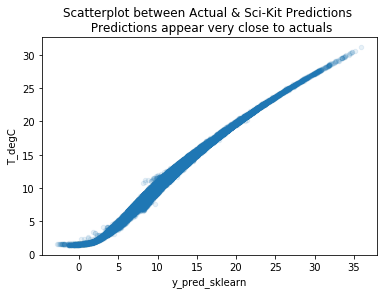

In [24]:
y_test.plot(kind="scatter", x="y_pred_sklearn", y="T_degC", alpha=.1,
            title="Scatterplot between Actual & Sci-Kit Predictions \n Predictions appear very close to actuals")

### Part D: Gradient Descent Mini-Batch

#### Add a column of 1s to X_train_scaled and X_test_scaled.

For the modelling work, I've started by adding an intercept column to both the  train and test predictor sets. The printout shows this was executed successfully.

In [183]:
X_train_scaled["Intercept"] = np.ones(len(X_train_scaled))
X_train_scaled = X_train_scaled[["Intercept", "Salnty", "STheta", "O2ml_L", "Depthm"]]

X_test_scaled["Intercept"] = np.ones(len(X_test_scaled))
X_test_scaled = X_test_scaled[["Intercept", "Salnty", "STheta", "O2ml_L", "Depthm"]]

,Intercept,Salnty,STheta,O2ml_L,Depthm
369164,1.0,1.565894,1.578154,-1.423225,2.492032
687155,1.0,-0.393199,-0.094318,0.669625,-0.675067
310468,1.0,-0.571299,-0.793409,1.143295,-0.642881
210295,1.0,0.145443,0.245326,-0.466218,-0.385393
721907,1.0,-0.977452,-1.102356,1.157795,-0.675067


The assignment calls for developing linear regression models with mini-batch gradient descent using different batch sizes. Additionally, it outlines the need to review train and test evaluation metrics alongside a scatterplot for the actuals versus predicted values. Given this coding work is repetitive since each batch size requires the same basic code structure, I've developed a function that develops the regression model using mini-batch gradient descent and then provides the metrics and plot in a dictionary, which can be accessed to review the work. The only input variable needed is the batch number; here, I'll be using 50, 250, and 2000 as mini-batch sizes. To eta and epoch size are set to .1 and 100 respectively.  

In [363]:
def gradient_batch_review(batch_n):

    theta_path_mgd = []

    m = len(X_train_scaled)
    n_iterations = 100
    minibatch_size = batch_n

    np.random.seed(1017)
    theta = np.random.randn(5, 1)

    for epoch in range(n_iterations):
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = np.array(X_train_scaled)[shuffled_indices]
        y_shuffled = np.array(y_train)[shuffled_indices]
        for i in range(0, m, minibatch_size):
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]
            gradients = 2 / minibatch_size * xi.T.dot(xi.dot(theta) - yi)
            eta = .1
            theta = theta - eta * gradients
            theta_path_mgd.append(theta)
            
    train_fitted = X_train_scaled.dot(theta)
    test_preds = X_test_scaled.dot(theta)
    
    theta_df = pd.DataFrame(theta, columns=["Coefficient"])
    theta_df["Variable"] = pd.Series(["Intercept", "Salnty", "STheta", "O2ml_L", "Depthm"], dtype="category")
    theta_df = theta_df[["Variable", "Coefficient"]]
    
    train_metrics = (metrics.r2_score(y_train["T_degC"], train_fitted).round(3),
                     metrics.mean_squared_error(y_train["T_degC"], train_fitted).round(3),
                     metrics.r2_score(y_train["T_degC"], train_fitted).round(4) * 100)
    
    test_metrics = (metrics.r2_score(y_test["T_degC"], test_preds).round(3),
                    metrics.mean_squared_error(y_test["T_degC"], test_preds).round(3),
                    metrics.r2_score(y_test["T_degC"], test_preds).round(4) * 100)
    
    model_metrics = pd.DataFrame({
        "Metric": pd.Series(["R2", "MSE", "Var_exp"], dtype="category"),
        "Test": list(test_metrics),
        "Train": list(train_metrics)
    })
    model_metrics = model_metrics[["Metric", "Train", "Test"]]
    
    y_test["y_pred"] = test_preds
    plot = y_test.plot(kind="scatter", x="y_pred", y="T_degC", alpha=.1,
                       title="Scatterplot between Actual & Predictions \n Predictions appear very close to actuals")
    
    print("Gradient Descent batch number:", batch_n)
    
    output = {"metrics": model_metrics, "theta": theta_df, "plot": plot}
    
    
    return(output)

#### 50 Batch Gradient Descent

The plot for actuals versus predicted shows the 50 batch size provides excellent predictions. 

Gradient Descent batch number: 50


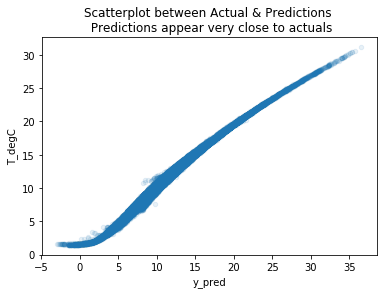

In [364]:
gradient_batch_50 = gradient_batch_review(batch_n=50)

In [351]:
gradient_batch_50["theta"]

,Variable,Coefficient
0,Intercept,10.948351
1,Salnty,1.692036
2,STheta,-4.731512
3,O2ml_L,0.284208
4,Depthm,-0.483179


However, it does not have metrics equal to the sci-kit learn predictions. There is also a small drop between train and test. As such, this does not seem like the best solution.

In [365]:
gradient_batch_50["metrics"]

,Metric,Train,Test
0,R2,0.994,0.993
1,MSE,0.116,0.117
2,Var_exp,99.350,99.340


#### 250 Batch Gradient Descent

The plot for actuals versus predicted shows the 250 batch size again highlights excellent predictions. 

Gradient Descent batch number: 250


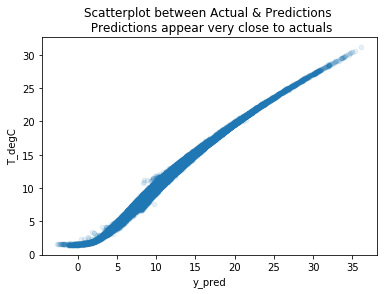

In [367]:
gradient_batch_250 = gradient_batch_review(batch_n=250)

It's alo evident that the regression coefficients are changing with increased batch size. These values are slightly different than the 50 batch.

In [369]:
gradient_batch_250["theta"]

,Variable,Coefficient
0,Intercept,10.930903
1,Salnty,1.655623
2,STheta,-4.663107
3,O2ml_L,0.287507
4,Depthm,-0.467058


These evaluation metrics are closer to the sci-kit predictions but, still far slightly shows. The train and test drop is still evident as well.

In [370]:
gradient_batch_250["metrics"]

,Metric,Train,Test
0,R2,0.994,0.994
1,MSE,0.111,0.112
2,Var_exp,99.380,99.370


#### 2000 Batch Gradient Descent

The plot for actuals versus predicted shows the 2000 batch size provides excellent predictions, which is not surprising at this point. 

Gradient Descent batch number: 2000


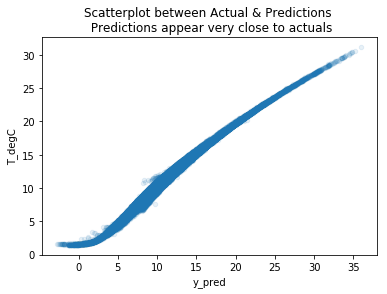

In [371]:
gradient_batch_2000 = gradient_batch_review(batch_n=2000)

The coefficients have changed slightly again here.

In [372]:
gradient_batch_2000["theta"]

,Variable,Coefficient
0,Intercept,10.919585
1,Salnty,1.643405
2,STheta,-4.643295
3,O2ml_L,0.301819
4,Depthm,-0.472341


Finally, the larger batch size shows metrics equal to the sci-kit predictions. Interestingly, these are achieved with coefficients that are slightly different as well, though the difference is nominal.

In [373]:
gradient_batch_2000["metrics"]

,Metric,Train,Test
0,R2,0.994,0.994
1,MSE,0.111,0.111
2,Var_exp,99.380,99.380


### Part E: Conceptual Questions

#### 1) Describe how parameter estimation in Gradient Descent differs from using the normal equation.

The normal equation computes parameters using a specified mathematical form (the equation). This means that the equation directly creates a best fit model using the given data. In contrast, gradient descent is a more iterative optimization approach. Using this method, the model parameters are continually updated over the training set as the given cost function is minimized. All considered, both methods will yield the same basic parameters but, the gradient descent approach is more iterative while the normal equation is a more fixed, closed equation.

#### 2) We used Mini-Batch Gradient descent here, but there are a variety of options for Gradient Descent. How is Mini-Batch Gradient Descent different from Stochastic Gradient Descent?

Stochastic gradient descent using a random point from the training data to compute gradient based on that point alone. In contrast to batch gradient descent which uses the entire set to compute gradients, thus becoming very slow and memory intensive, stochastic is computational efficient. However, because these points are chosen at random (i.e. stochastic) the gradient training can become irregular making jumps. While it can eventually come close to a minimum, the approach can still jump around when there so the final parameters are not as good as other methods. Mini-batch offers a compromise between batch and stochastic gradient descent because instead of using the whole set or one point, it uses a small set of randomized training data to compute gradients. This means that the method still has some jumping around but, is less erratic than the stochastic method. Overall, min-batch ends up being a more powerful than the stochastic variant which can result in performance boosts.

#### 3) Identify your best-performing version of Gradient Descent and compare the error metrics for test data vs training data. Does this version of gradient descent show signs of overfitting? Explain.

The best performing gradient descent I had was with 2000 batches. This not only showed the highest test metrics but, the best convergence between training and test. Overall, because the training and test metrics were fairly even throughout, none of the models showed any major overfitting. Overfitting occurs when there is a large variance between training and test metrics, which is not on display here. While the 250 and 50 batches showed some deviance between train and test but, even these were quite close so overall, I don’t think overfitting was an issue here.

#### 4) Explain what the learning rate is for. Even though we did not, why might it be helpful to change the learning rate over time?

Learning rate is the hyperparameter that controls the size of steps in gradient descent. Smaller learning rates means a slower convergence given the gradient descent has to go through more steps before finding a minimum. Conversely, a higher rate might find a convergence quicker but, also runs the risk of oscillating between two sides (jumping). This trade-off highlights why changing the rate over time might be useful. Starting high might be a good way to work towards convergence while also escaping local minima but, it might be a good choice to reduce the rate once close to the final point. For these reasons, it’s helpful to augment the learning rate over time, which in practice can be done by a function known as a learning schedule.

#### 5) Why would a data scientist want to use early stopping in gradient descent?

Early stopping can be essential because it helps avoid overfitting. In gradient descent, the learner might be at the bottom of the bowl or general convex but, slowly working towards a minimum without much progress. At this point, there might be a good solution but, continuing to look for a perfect minimum is time consuming. Further, this continued search may encourage overfitting where the iterations are over tuning the parameters on the training sample, which can hinder test performance. With this in mind, early stopping in gradient descent acts as a regularization method.

In [374]:
import os
os.getcwd()

'C:\\Users\\Mark\\Machine Learning 2'